In [1]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt

In [8]:
def sift_match(img_l,img_r,task="task1"):
    img_l_gray = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
    img_r_gray = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)
    
    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp_l,des_l = sift.detectAndCompute(img_l_gray,None)
    kp_r,des_r = sift.detectAndCompute(img_r_gray,None)
    
    cv2.imwrite("../"+task+"_img/"+task+"_sift1.jpg", cv2.drawKeypoints(img_l_gray, kp_l, None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    cv2.imwrite("../"+task+"_img/"+task+"_sift2.jpg", cv2.drawKeypoints(img_r_gray, kp_r, None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des_l,des_r,k=2)

    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])

    img_res = cv2.drawMatchesKnn(img_l,kp_l,img_r,kp_r,good[10:20],None,flags=2)
    cv2.imwrite("../"+task+"_img/"+task+"_matches_knn.jpg",img_res)
    return kp_l, des_l, kp_r, des_r, good

In [9]:
def draw_match_img(img_l, img_r, kp_l, des_l, kp_r, des_r, good):
    img_l_gray = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
    img_r_gray = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)
    ## Use the FLANN
    MIN_MATCH_COUNT = 10
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([ kp_l[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_r[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
        h,w= img_l_gray.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        img_r_gray = cv2.polylines(img_r_gray,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    else:
        print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
        matchesMask = None
        
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask[:10], # draw only inliers
                   flags = 2)
    img5 = cv2.drawMatches(img_l_gray,kp_l,img_r_gray,kp_r, list(map(lambda x: x[0], good[:10])) ,None,**draw_params)
    cv2.imwrite('../task1_img/task1_matches.jpg',img5)
    return M

In [10]:
filename_1 = '../task1_img/mountain1.jpg'
filename_2 = '../task1_img/mountain2.jpg'
img_l = cv2.imread(filename_1) # trainImage
img_r = cv2.imread(filename_2) # queryImage
img_r_gray = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)
img_l_gray = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)

In [11]:
kp_l, des_l, kp_r,des_r, good = sift_match(img_l, img_r, task="task1")

In [12]:
M = draw_match_img(img_l, img_r, kp_l, des_l, kp_r, des_r, good)
print("homography matrix:")
print(M)

homography matrix:
[[ 1.58799966e+00 -2.91541838e-01 -3.95539425e+02]
 [ 4.48199617e-01  1.43139761e+00 -1.90370131e+02]
 [ 1.20864262e-03 -5.94920214e-05  1.00000000e+00]]


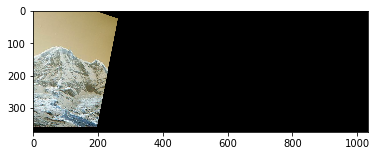

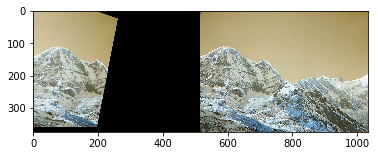

(<matplotlib.image.AxesImage at 0x1197bf5f8>, None)

In [13]:
## wrap left, but only show part of image.
result = cv2.warpPerspective(img_l, M, (img_l.shape[1] + img_r.shape[1], img_l.shape[0]))
result[0:img_r.shape[0], img_l.shape[1]:img_l.shape[1]+img_r.shape[1]] = img_r